# MCMC light case, again

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters, likelihood_levels_1d
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis

In [18]:
from mcmc_utils import light_minimal_mcmc

from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [19]:
hierarchy = 'light'
D_or_M = 'dirac'

set_backend = True
reset_backend = False
n_samples = 4000

spec = 'minimal tpc only logs minus'

set_plot_style()

In [20]:
this_dark_nus_mcmc = light_minimal_mcmc(hierarchy, D_or_M, title_addition=spec)

light dirac FHC
Wall time: 0.35550999641418457 s, CPU time: 0.34114575800001035
light dirac RHC
Wall time: 0.3616912364959717 s, CPU time: 0.34794627900001274


# Prepare the dataset to minimize computation

In [21]:
tpc_light_analysis = analyses['tpc_light']

In [22]:
basic_weights = {}
for nu_mode in ['FHC', 'RHC']:
    exp_analysis = this_dark_nus_mcmc.exp_analysis_objs[f'{hierarchy}_{D_or_M}_{nu_mode}']
    exp_analysis.df_base = exp_analysis.df_base.query(tpc_light_analysis['FHC']['selection'] + ' & argon')
    aux_weights = deepcopy(exp_analysis.df_base['generator_weight'])
    aux_weights /= exp_analysis.Vmu4_alpha_epsilon2
    aux_weights *= exp_analysis.compute_pot_ntarget_weights(exp_analysis.df_base, 
                                                            tpc_light_analysis[nu_mode]['n_target'], 
                                                            tpc_light_analysis[nu_mode]['pot'])
    aux_weights *= tpc_light_analysis[nu_mode]['efficiency']
    basic_weights[nu_mode] = aux_weights

In [23]:
ndim = 3
def light_posterior_tpc_analysis_only(parameters):
    '''Posterior in the light minimal model with no geometry: parameters = [log10_m4, log10_mz, log10_Vmu4_alpha_epsilon2]
       It uses global pars to speed up parallel computation'''
    actual_m4 = 10**parameters[0]
    actual_mz = 10**parameters[1]
    actual_Vmu4_alpha_epsilon2 = 10**parameters[2]
    if (actual_m4 < this_dark_nus_mcmc.m4_limits[0]) or\
       (actual_m4 > this_dark_nus_mcmc.m4_limits[1]) or\
       (actual_mz < this_dark_nus_mcmc.mz_limits[0]) or\
       (actual_mz > this_dark_nus_mcmc.mz_limits[1]) or\
       (actual_m4 <= actual_mz) or\
       (actual_Vmu4_alpha_epsilon2 <= 100*this_dark_nus_mcmc.lower_bound_Vmu4_alpha_epsilon2) or\
       (actual_Vmu4_alpha_epsilon2 > this_dark_nus_mcmc.upper_bound_Vmu4_alpha_epsilon2):
        return -np.inf, -np.inf, -np.inf
    else:
        like = 0
        mu = 0
        sigma2 = 0
        for nu_mode in ['FHC', 'RHC']:
            this_analysis = this_dark_nus_mcmc.exp_analysis_objs[f'{hierarchy}_{D_or_M}_{nu_mode}']
            this_weights = this_analysis.kde_on_a_point(this_analysis.df_base, 
                                          (actual_m4, actual_mz))
            this_weights *= basic_weights[nu_mode]
            this_weights *= actual_Vmu4_alpha_epsilon2
            out = this_analysis.compute_likelihood(
                    this_analysis.df_base, 
                    this_weights, 
                    analysis=tpc_light_analysis[nu_mode], 
                    like_normalized=False)
            like -= out[0]
            mu += out[1]
            sigma2 += out[3]
        return like, mu, sigma2 

labels = ['log10_m4', 'log10_mz', 'log10_Vmu4_alpha_epsilon2']
blobs_dtype = [('mu', float), ('sigma2', float)]

In [24]:
light_posterior_tpc_analysis_only([np.log10(0.1), np.log10(0.03), np.log10(0.25*2e-10*8e-9)])

(0.8788594533304832, 0.28215876998376765, 0.02393163980409195)

In [25]:
this_dark_nus_mcmc.set_posterior(light_posterior_tpc_analysis_only, 
                                 ndim, 
                                 labels=labels)

In [26]:
with Pool() as pool:
    this_dark_nus_mcmc.initialise_mcmc(ndim**2, pool,
                                       set_backend=set_backend, reset_backend=reset_backend, 
                                       blobs_dtype=blobs_dtype, log_ms=True)
    # this_dark_nus_mcmc.run_mcmc(n_samples)

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.55555556        nan        nan]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.95157779 0.72147866 1.19321679]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [1.91135729 2.15790928 2.10488942]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1;
tau: [3.83328522 3.69803682 4.32675599]
The chain is shorter than 50 times the integrated au

(4000, 9, 3)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


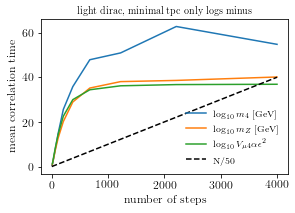

In [27]:
this_dark_nus_mcmc.compute_autocorrelation_time(store=True)

In [28]:
this_dark_nus_mcmc.get_samples(discard=5, thin=1)

(<Figure size 864x504 with 4 Axes>,
 array([<AxesSubplot:ylabel='$\\log_{10}m_4$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}m_Z$ [GeV]'>,
        <AxesSubplot:ylabel='$\\log_{10}V_{\\mu 4}\\alpha \\epsilon^2$'>,
        <AxesSubplot:xlabel='step number', ylabel='log(p)'>], dtype=object))

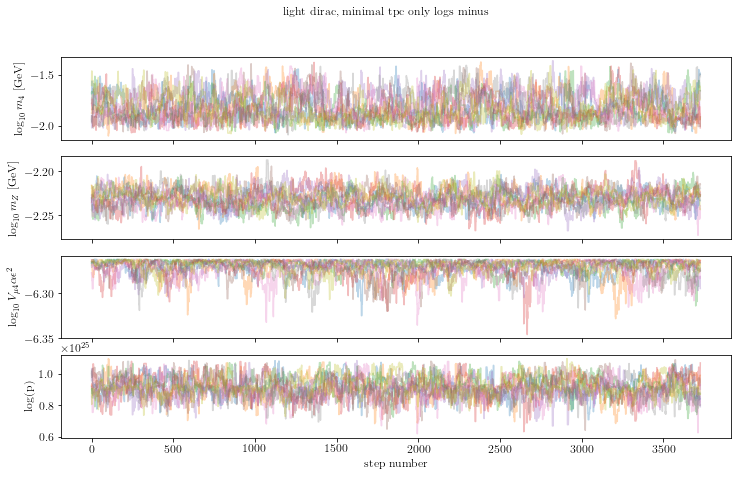

In [29]:
this_dark_nus_mcmc.plot_chains(store=True)

ValueError: Contour levels must be increasing

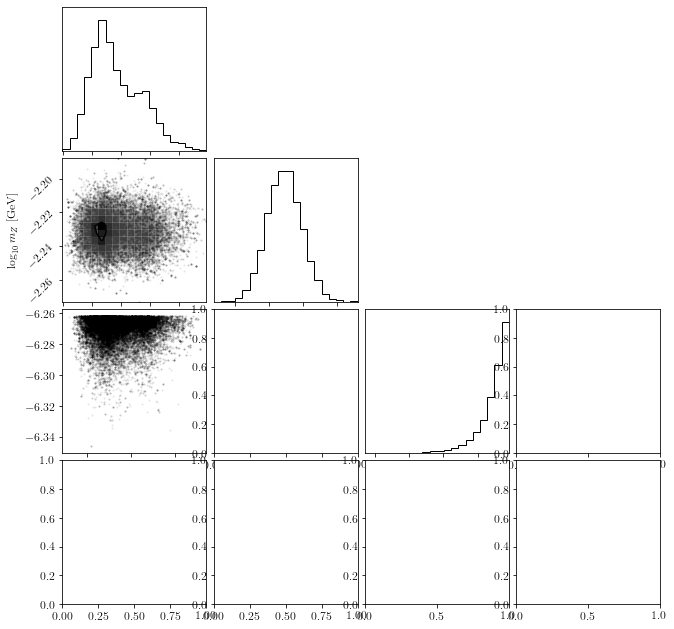

In [37]:
this_dark_nus_mcmc.corner_plot_raw(savefile='raw_corner')

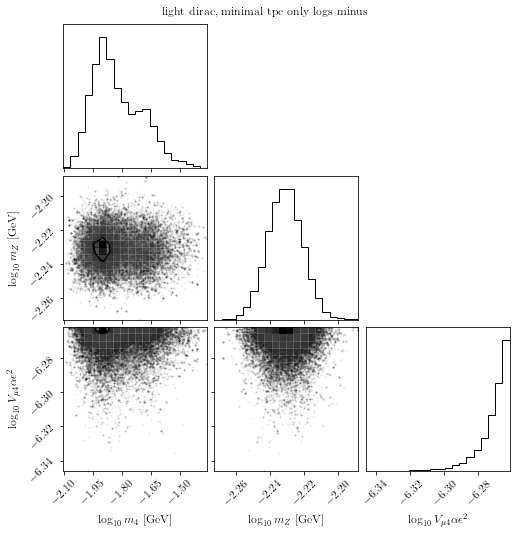

In [48]:
this_dark_nus_mcmc.corner_plot_physics(savefile='physics_corner')

In [32]:
print('Fraction of samples with null expectation =', (this_dark_nus_mcmc.samples['mu'] == 0).sum()/len(this_dark_nus_mcmc.samples))

Fraction of samples with null expectation = 0.0


Removed no burn in


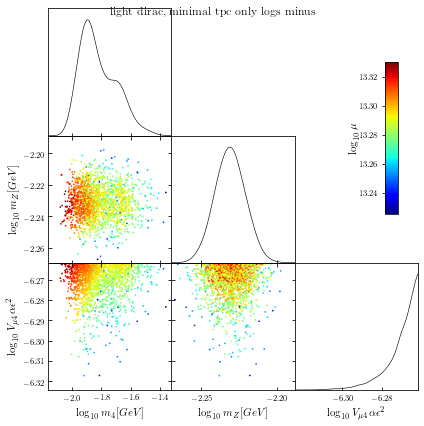

In [39]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_mu', savefile='corner_log10_mu')

Removed no burn in


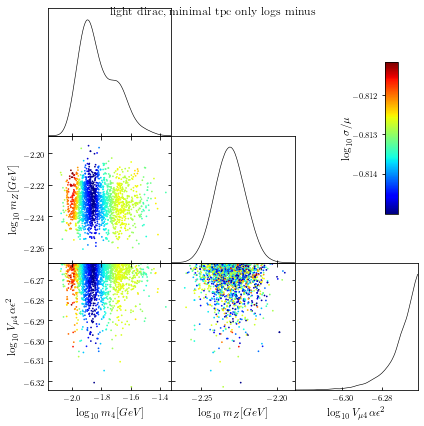

In [34]:
this_dark_nus_mcmc.corner_plot_with_colour('log10_sigma/mu', savefile='corner_log10_sigma_mu')

Removed no burn in


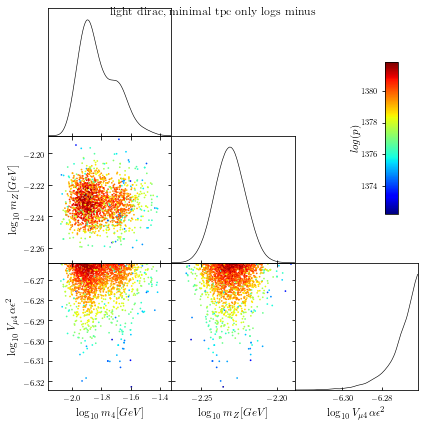

In [40]:
this_dark_nus_mcmc.corner_plot_with_colour('log(p)', savefile='corner_log10_ctau')